In [1]:
import ot.gromov
import ot
from nilearn import datasets
import numpy as np
from scipy import stats
import networkx as nx
import torch
from torch_geometric.data import Data
import matplotlib.colors as mcol
from matplotlib import cm
from ot.gromov import fgw_barycenters
from scipy.sparse.csgraph import shortest_path
import math

# Load data

In [2]:
from nilearn import datasets

abide = datasets.fetch_abide_pcp(
    data_dir="/Users/balazsmorvay/Downloads/nilearn_data",
    derivatives="rois_cc200",
    pipeline="cpac",
    band_pass_filtering=True,
    global_signal_regression=True,
    quality_checked=True,
)

[fetch_abide_pcp] Dataset found in /Users/balazsmorvay/Downloads/nilearn_data/ABIDE_pcp


# Utilities

In [3]:
def corr_fisher_z(X):  # X: (T, N) ROI time-series
    C = np.corrcoef(X, rowvar=False)          # (N, N)
    C = np.clip(C, -0.999999, 0.999999)
    Z = np.arctanh(C)                         # Fisher z
    np.fill_diagonal(Z, 0.0)
    return Z

def top_p_sparsify(W, p=0.10, keep_positive=True):
    """Keep top p% absolute (or positive) weights per *whole matrix*."""
    Wc = W.copy()
    if keep_positive:
        Wc[Wc < 0] = 0
    flat = Wc.flatten()
    k = max(1, int(len(flat) * p))
    thr = np.partition(flat, -k)[-k]  # global threshold
    A = (Wc >= thr).astype(float) * Wc
    # symmetrize
    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)
    return A

def make_node_features(Z, mode='corr_row'):
    """
    'corr_row' -> node i feature = i-th row of Z (NeuroGraph style)
    'none'     -> no explicit node features (ones)
    """
    N = Z.shape[0]
    if mode == 'corr_row':
        X = Z.copy()
        np.fill_diagonal(X, 0.0)
        return X
    return np.ones((N, 1), dtype=float)

def to_pyg(A, X, y=None, meta=None):
    if Data is None:
        return dict(edge_index=None, edge_weight=None, x=X, y=y, meta=meta)
    # build edge_index/weight from upper triangle
    i, j = np.where(np.triu(A, 1) > 0)
    w = A[i, j]
    # make undirected (i<->j)
    ei = np.vstack([np.hstack([i, j]), np.hstack([j, i])])
    ew = np.hstack([w, w]).astype(np.float32)
    x = torch.tensor(X, dtype=torch.float32)
    data = Data(x=x,
                edge_index=torch.tensor(ei, dtype=torch.long),
                edge_weight=torch.tensor(ew),
                y=None if y is None else torch.tensor([y], dtype=torch.long))
    data.meta = meta
    return data

def graph_colors(nx_graph, attr_name = "attr_name", vmin=0, vmax=7):
    cnorm = mcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap="viridis")
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(nx_graph, attr_name).items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in nx_graph.nodes():
        colors.append(val_map[node])
    return colors

# Build one graph per subject

In [4]:
graphs = []
normalized_node_features = []
for i, ts in enumerate(abide.rois_cc200):
    pheno = abide.phenotypic.iloc[i]
    # 3.1 connectivity (Fisher-z of Pearson corr)
    Z = corr_fisher_z(ts)
    # 3.2 sparsify like NeuroGraph (e.g., top 10% positive edges)
    # A = top_p_sparsify(Z, p=0.10, keep_positive=True)
    # 3.3 node features (corr row vectors)
    X = make_node_features(Z, mode='corr_row')
    X = np.nanmax(X) - X
    np.fill_diagonal(X, 0.0)
    if np.isnan(X.max()):
        print(f"nan in {i}")
    normalized_node_features.append(X)
    # 3.4 label: ASD(1)/HC(2) in ABIDE PCP; convert to 0/1
    dx = pheno.get('DX_GROUP')
    y = None if dx is None else int(dx == 1)  # 1=ASD -> 1, 2=HC -> 0
    # 3.5 site/domain
    site = pheno.get('SITE_ID', pheno.get('SITE_NAME', 'NA'))
    graphs.append(to_pyg(Z, X, y=y, meta={'site': site, 'age': pheno.get('AGE_AT_SCAN')}))

print(f'Built {len(graphs)} graphs (static). Example meta:', graphs[0].meta if graphs else None)

nan in 36
nan in 105
nan in 113
nan in 125
nan in 149
nan in 150


/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


nan in 392
nan in 394
nan in 401
nan in 589
nan in 641
nan in 830
nan in 832
nan in 838
nan in 845
Built 871 graphs (static). Example meta: {'site': 'PITT', 'age': np.float64(24.45)}


In [5]:
len(graphs), graphs[0]
# Data(
#    x=[200, 200], # node features: 200 ROIs correlation matrix
#    edge_index=[2, 4000], # directed edge list, 4000 directed = 2000 undirected, approx. 10% of all edges
#    y=[1], # label: 1=ASD, 0=HC
#    edge_weight=[4000], # edge weights: Fisher-z correlation values
#    meta={
#      site='PITT',
#      age=13.73,
#    }
#  )

(871,
 Data(
   x=[200, 200],
   edge_index=[2, 19456],
   y=[1],
   edge_weight=[19456],
   meta={
     site='PITT',
     age=24.45,
   }
 ))

# PyG to NetworkX graphs

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx

nx_graphs = []
for g in graphs:
    G = to_networkx(
        g,
        node_attrs=['x'],                 # keep node feature vectors
        edge_attrs=['edge_weight'],       # keep weights
        to_undirected=True,               # collapse i→j and j→i duplicates
        remove_self_loops=True
    )
    # stash graph-level info
    G.graph.update({
        'label': int(g.y.item()) if g.y is not None else None,
        **(g.meta or {})
    })
    nx_graphs.append(G)

# Example: first graph
G0 = nx_graphs[0]
print(type(G0), G0.number_of_nodes(), G0.number_of_edges())
# node feature of ROI 0: G0.nodes[0]['x']  -> numpy/torch vector length 200
# edge weight: G0[u][v]['edge_weight']

<class 'networkx.classes.graph.Graph'> 200 9728


In [7]:
# Get all sites and their cardinality from nx_graphs
from collections import Counter

sites = [G.graph['site'] for G in nx_graphs]
site_counts = Counter(sites)

# Get labels for each graph
labels = [G.graph['label'] for G in nx_graphs]

# Count labels per site
site_label_counts = {}
for G in nx_graphs:
    site = G.graph['site']
    label = G.graph['label']
    if site not in site_label_counts:
        site_label_counts[site] = {0: 0, 1: 0}
    site_label_counts[site][label] += 1

# Sort by cardinality (descending)
sorted_sites = sorted(site_counts.items(), key=lambda x: x[1], reverse=True)

print("Site Cardinality and Label Distribution:")
print("-" * 60)
print(f"{'Site':<20s} {'Total':>6s} {'Label 0':>8s} {'Label 1':>8s}")
print("-" * 60)
for site, count in sorted_sites:
    label_0 = site_label_counts[site][0]
    label_1 = site_label_counts[site][1]
    print(f"{site:<20s} {count:>6d} {label_0:>8d} {label_1:>8d}")
print("-" * 60)
print(f"Total sites: {len(site_counts)}")
print(f"Total graphs: {len(nx_graphs)}")
print(f"Total Label 0: {sum(1 for l in labels if l == 0)}")
print(f"Total Label 1: {sum(1 for l in labels if l == 1)}")

Site Cardinality and Label Distribution:
------------------------------------------------------------
Site                  Total  Label 0  Label 1
------------------------------------------------------------
NYU                     172       98       74
UM_1                     86       52       34
USM                      67       24       43
UCLA_1                   64       27       37
PITT                     50       26       24
MAX_MUN                  46       27       19
TRINITY                  44       25       19
YALE                     41       19       22
UM_2                     34       21       13
KKI                      33       21       12
OLIN                     28       14       14
LEUVEN_1                 28       14       14
LEUVEN_2                 28       16       12
SDSU                     27       19        8
SBL                      26       14       12
OHSU                     25       13       12
STANFORD                 25       13       12
UCLA_2   

In [8]:
sites = [G.graph['site'] for G in nx_graphs]

nyu_1 = [G for G in nx_graphs if G.graph['site'] == 'NYU' and G.graph['label'] == 1]
nyu_0 = [G for G in nx_graphs if G.graph['site'] == 'NYU' and G.graph['label'] == 0]

pitt_1 = [G for G in nx_graphs if G.graph['site'] == 'PITT' and G.graph['label'] == 1]
pitt_0 = [G for G in nx_graphs if G.graph['site'] == 'PITT' and G.graph['label'] == 0]

usm_1 = [G for G in nx_graphs if G.graph['site'] == 'USM' and G.graph['label'] == 1]
usm_0 = [G for G in nx_graphs if G.graph['site'] == 'USM' and G.graph['label'] == 0]

nyu_1_features = [normalized_node_features[i] for i, G in enumerate(nx_graphs) if
                  G.graph['site'] == 'NYU' and G.graph['label'] == 1]
nyu_0_features = [normalized_node_features[i] for i, G in enumerate(nx_graphs) if
                  G.graph['site'] == 'NYU' and G.graph['label'] == 0]

pitt_1_features = [normalized_node_features[i] for i, G in enumerate(nx_graphs) if
                   G.graph['site'] == 'PITT' and G.graph['label'] == 1]
pitt_0_features = [normalized_node_features[i] for i, G in enumerate(nx_graphs) if
                   G.graph['site'] == 'PITT' and G.graph['label'] == 0]

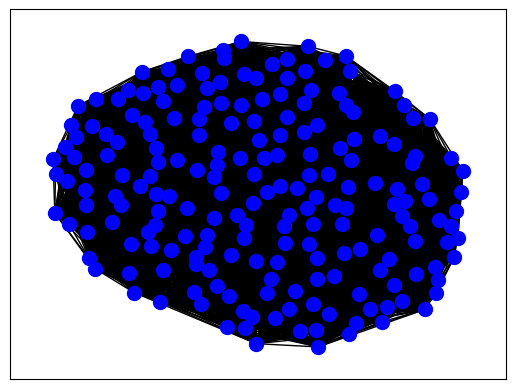

In [9]:
pos = nx.kamada_kawai_layout(nx_graphs[1])
nx.draw_networkx(
    nx_graphs[1],
    pos=pos,
    node_color="blue",
    with_labels=False,
    node_size=100,
)

# Barycenter computations

In [10]:
def gw_barycenter(graphs, Cs):
    # Cs = [shortest_path(nx.adjacency_matrix(g).toarray()) for g in graphs]
    # Cs = [np.where(np.isinf(C), 200, C) for C in Cs]
    # Cs = normalized_node_features[0:100]
    # Cs = [np.where(np.isnan(C), 200, C) for C in Cs]
    ps = [np.ones(len(g.nodes())) / len(g.nodes()) for g in graphs]

    return ot.gromov.gromov_barycenters(N=200,
                                 Cs=Cs,
                                 ps=ps,
                                 p=None, # Uniform
                                 lambdas=None, # Uniform
                                 loss_fun="square_loss",
                                 symmetric=True,
                                 armijo=False, # If convergence issues, use False
                                 max_iter=100,
                                 tol=1e-2,
                                 stop_criterion="loss",
                                 warmstartT=False,
                                 verbose=True,
                                 log=False,
                                 init_C=None,
                                 random_state=42)

In [11]:
nyu_0_barycenter = gw_barycenter(nyu_0, [np.where(np.isnan(C), 200, C) for C in nyu_0_features])
nyu_1_barycenter = gw_barycenter(nyu_1, [np.where(np.isnan(C), 200, C) for C in nyu_1_features])
pitt_0_barycenter = gw_barycenter(pitt_0, [np.where(np.isnan(C), 200, C) for C in pitt_0_features])
pitt_1_barycenter = gw_barycenter(pitt_1, [np.where(np.isnan(C), 200, C) for C in pitt_1_features])

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.583300e+00|0.000000e+00|0.000000e+00
    1|1.580194e+00|1.965780e-03|3.106313e-03
    2|1.569604e+00|6.746838e-03|1.058987e-02
    3|1.558297e+00|7.256313e-03|1.130749e-02
    4|1.557187e+00|7.128502e-04|1.110041e-03
    5|1.556962e+00|1.442633e-04|2.246125e-04
    6|1.556705e+00|1.648866e-04|2.566799e-04
    7|1.556454e+00|1.617823e-04|2.518067e-04
    8|1.556275e+00|1.145576e-04|1.782831e-04
    9|1.556124e+00|9.727108e-05|1.513658e-04
   10|1.555997e+00|8.178158e-05|1.272519e-04
   11|1.555896e+00|6.435413e-05|1.001284e-04
   12|1.555829e+00|4.336054e-05|6.746158e-05
   13|1.555802e+00|1.742464e-05|2.710929e-05
   14|1.555789e+00|8.411060e-06|1.308583e-05
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.362738e+00|0.000000e+00|0.000000e+00
    1|1.359193e+00|2.607952e-03|3.544709e-03
    2|1.347052e+00|9.012762e-03|1.214066e-0

# Visualize a barycenter

In [12]:
# Create a NetworkX graph from the barycenter adjacency matrix
A = top_p_sparsify(pitt_0_barycenter, p=0.1, keep_positive=True)
G_barycenter = nx.from_numpy_array(A)
print(f"Barycenter graph: {G_barycenter.number_of_nodes()} nodes, {G_barycenter.number_of_edges()} edges")

Barycenter graph: 200 nodes, 2000 edges


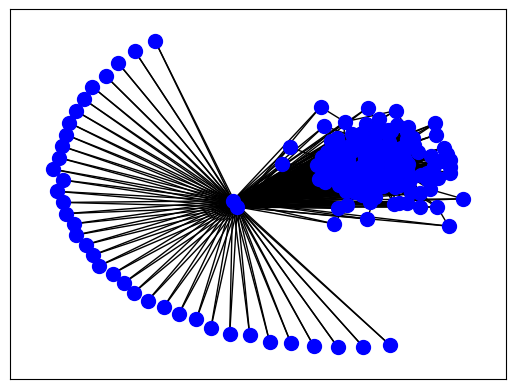

In [13]:
pos = nx.kamada_kawai_layout(G_barycenter)
nx.draw_networkx(
    G_barycenter,
    pos=pos,
    node_color="blue",
    with_labels=False,
    node_size=100,
)

# Compare new site

In [14]:
usm_1_features = [normalized_node_features[i] for i, G in enumerate(nx_graphs) if
                  G.graph['site'] == 'USM' and G.graph['label'] == 1]
usm_0_features = [normalized_node_features[i] for i, G in enumerate(nx_graphs) if
                  G.graph['site'] == 'USM' and G.graph['label'] == 0]

In [24]:
correct = 0
incorrect = 0

for i in range(len(usm_0_features)):
    Cs = np.where(np.isnan(usm_0_features[i]), 200, usm_0_features[i])
    dist_0 = ot.gromov_wasserstein2(C1=Cs, C2=pitt_0_barycenter, p=ot.unif(Cs.shape[0]), q=ot.unif(pitt_0_barycenter.shape[0]))
    dist_1 = ot.gromov_wasserstein2(C1=Cs, C2=pitt_1_barycenter, p=ot.unif(Cs.shape[0]), q=ot.unif(pitt_1_barycenter.shape[0]))
    print(dist_0, dist_1)
    if dist_0 < dist_1:
        correct += 1
    else:
        incorrect += 1

print(correct, incorrect)

1.1911504600037432 0.07263833564484733
1.2676202460421824 0.06878011142693698
1.4025754632649727 0.14797751339325282
1.2538771770117911 0.22535116105443434
1.298630883220561 0.08672306551504942
1.3078988646942036 0.09240593462673698
1.3420922599621325 0.10385859082500055
1.3151742158321296 0.09422861851673556
1.347140498466736 0.11659842043752103
1.464158653291044 0.18602448202819635
1.3222478077124222 0.09473242882097208
1.3291670922921224 0.10557261153965355
1.213861673947109 0.057168690644441286
1.4243687934099383 0.16116142026438204
1.1860166826611451 0.07991792715240305
1.212827492589923 0.0535508143054633
1.1906178095274307 0.07573347435312418
1.2075912670969988 0.07218558337425232
1.3179209003020564 0.09489972170919067
1.4443261096321733 0.17732092929755466
1.249697789377235 0.06798250733002861
1.2106930312079627 0.05302932946933586
1.2666179195743275 0.06460995083247131
1.3066066009592134 0.11596714528260174
0 24


In [23]:
for i in range(len(usm_1_features)):
    Cs = np.where(np.isnan(usm_1_features[i]), 200, usm_1_features[i])
    dist_0 = ot.gromov_wasserstein2(C1=Cs, C2=nyu_0_barycenter, p=ot.unif(Cs.shape[0]), q=ot.unif(nyu_0_barycenter.shape[0]))
    dist_1 = ot.gromov_wasserstein2(C1=Cs, C2=nyu_1_barycenter, p=ot.unif(Cs.shape[0]), q=ot.unif(nyu_1_barycenter.shape[0]))
    print(dist_0, dist_1)
    if dist_0 > dist_1:
        correct += 1
    else:
        incorrect += 1

print(correct, incorrect)

0.2875110496270439 0.1103198281624907
0.3064677643206858 0.1247006076191289
0.2179930810038166 0.05405029375252871
0.20364729026837108 0.04121290132244278
0.20774915455272758 0.0452756745981555
0.2800883195004945 0.13708798081864373
0.19600198662398355 0.03865228060285363
0.20427083516851444 0.04963905494982817
0.3191722755583014 0.18059729639830943
0.21237689344583494 0.05787580006723878
0.2566949182218395 0.08018658178082212
0.2262829316999749 0.054217439576475866
0.4683290006413647 0.27247937248099363
0.207938606534242 0.03932743771698833
0.2167758888811681 0.06977889916311517
0.32723619811273896 0.14298183527480626
0.22937167462213562 0.056696691862738194
0.23486315292265192 0.06579656589532162
0.20668366873776647 0.0404509609775412
0.38858499027550103 0.2542451693139801
0.20577124755856396 0.05226728897158639
0.3392067091814165 0.1544985306686151
0.23607231471101672 0.06390833226194899
0.2039723172498927 0.053700844818204925
0.2383967580308605 0.07725266108654369
0.220087261675210